In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout
from keras import Sequential
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

## Step 1 - Gathering and Exploring Data

Let us first download the data for 3 ETFs.

In [473]:
equity = yf.Ticker("SPY").history(start="2012-01-01", end="2022-12-31")
crude_oil = yf.Ticker("DBO").history(start="2012-01-01", end="2022-12-31")
gold = yf.Ticker("GLD").history(start="2012-01-01", end="2022-12-31")

In [475]:
equity.head() #first look at the data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2012-01-03 00:00:00-05:00,100.958312,101.448249,100.697538,100.752853,193697900,0.0,0.0,0.0
2012-01-04 00:00:00-05:00,100.515787,100.997821,100.128582,100.910896,127186500,0.0,0.0,0.0
2012-01-05 00:00:00-05:00,100.365632,101.329694,99.907304,101.179550,173895000,0.0,0.0,0.0
2012-01-06 00:00:00-05:00,101.306013,101.321821,100.586918,100.918808,148050000,0.0,0.0,0.0
2012-01-09 00:00:00-05:00,101.147972,101.290206,100.681746,101.163780,99530200,0.0,0.0,0.0


In [477]:
crude_oil.head() #fist look at the data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2012-01-03 00:00:00-05:00,25.796447,26.094875,25.770116,26.042212,318300,0.0,0.0,0.0
2012-01-04 00:00:00-05:00,25.954440,26.235313,25.884221,26.165094,422800,0.0,0.0,0.0
2012-01-05 00:00:00-05:00,26.015880,26.244090,25.796448,25.814003,249700,0.0,0.0,0.0
2012-01-06 00:00:00-05:00,26.015880,26.015880,25.673566,25.919331,357900,0.0,0.0,0.0
2012-01-09 00:00:00-05:00,25.849113,25.875444,25.550685,25.831558,213900,0.0,0.0,0.0


In [479]:
gold.head() #first look at the gold data etf

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2012-01-03 00:00:00-05:00,154.759995,156.300003,154.550003,155.919998,13385800,0.0,0.0,0.0
2012-01-04 00:00:00-05:00,155.429993,157.380005,155.339996,156.710007,11549700,0.0,0.0,0.0
2012-01-05 00:00:00-05:00,155.369995,158.029999,155.250000,157.779999,11621600,0.0,0.0,0.0
2012-01-06 00:00:00-05:00,158.589996,158.630005,156.380005,157.199997,9790500,0.0,0.0,0.0
2012-01-09 00:00:00-05:00,157.360001,157.589996,156.190002,156.500000,8771900,0.0,0.0,0.0


Let us collect the closing prices for all these 3 ETFs.

In [482]:
equity = equity["Close"]
crude_oil = crude_oil["Close"]
gold = gold["Close"]

Now let us take a look at the summary statistics for all 3 series separately

In [485]:
equity.describe()

count    2768.000000
mean      235.405478
std        95.768907
min       100.752853
25%       164.101761
50%       214.698448
75%       290.399063
max       457.181610
Name: Close, dtype: float64

In [487]:
crude_oil.describe()

count    2768.000000
mean       13.566288
std         6.701342
min         4.713807
25%         8.221967
50%        10.671495
75%        21.179596
max        27.981993
Name: Close, dtype: float64

In [489]:
gold.describe()

count    2768.000000
mean      138.611351
std        23.276570
min       100.500000
25%       119.495001
50%       127.550003
75%       162.070007
max       193.889999
Name: Close, dtype: float64

Let us try to visualize the time series for all three ETFs.

Text(0.5, 1.0, 'SPY ETF Closing Prices')

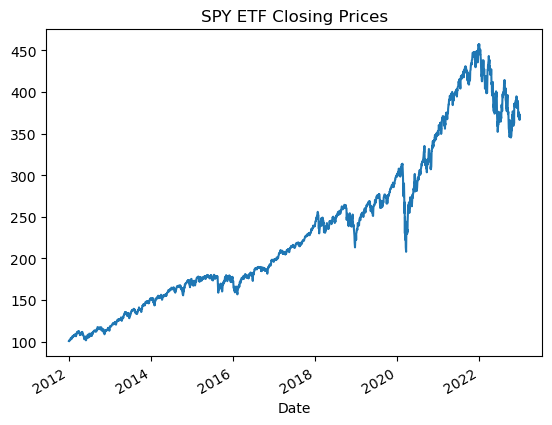

In [492]:
equity.plot()
plt.title("SPY ETF Closing Prices")

Text(0.5, 1.0, 'Invesco DB Oil Fund Closing Prices')

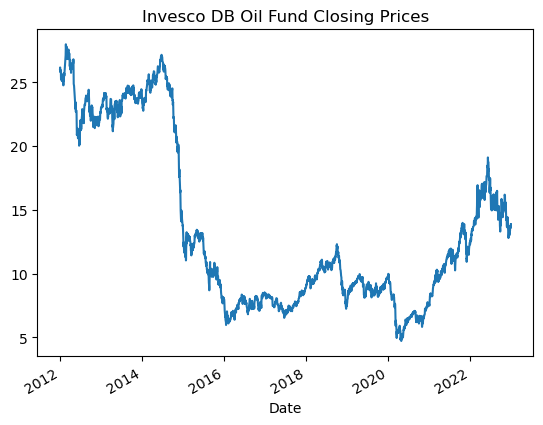

In [493]:
crude_oil.plot()
plt.title("Invesco DB Oil Fund Closing Prices")

Text(0.5, 1.0, 'Gold ETF Closing Prices')

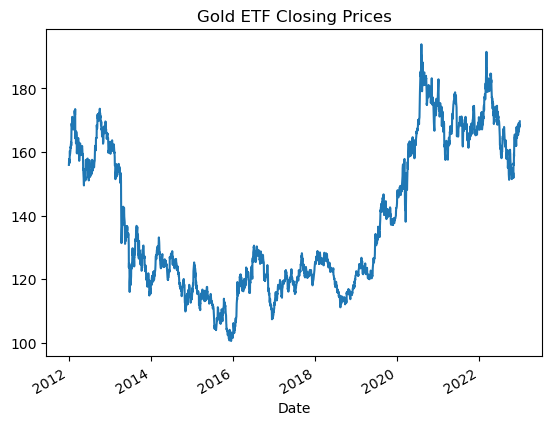

In [495]:
gold.plot()
plt.title("Gold ETF Closing Prices")

Upon inspection, we can see that while all 3 ETFs see an overall rise in their prices over time, the gold ETF rises during the period around 2020-2021, when the first wave of covid struck. The equity and the oil ETFs see a dip in this same period.

Let us have a look at the skew and the kurtosis of all 3 ETFs

In [498]:
print("The skew and kurtosis in the Equity ETF data is {0} and {1} respectively".format(equity.skew(), equity.kurtosis()))
print("The skew and kurtosis in the Oil ETF data is {0} and {1} respectively".format(crude_oil.skew(), crude_oil.kurtosis()))
print("The skew and kurtosis in the Gold ETF data is {0} and {1} respectively".format(gold.skew(), gold.kurtosis()))

The skew and kurtosis in the Equity ETF data is 0.6422238170745936 and -0.6606506135067125 respectively
The skew and kurtosis in the Oil ETF data is 0.7384448510219546 and -0.9998038426926885 respectively
The skew and kurtosis in the Gold ETF data is 0.39954065132761857 and -1.3152042787043552 respectively


Now, let us check for the stationarity of each series individually

In [501]:
#First, the Equity ETF
adf_result_equity = adfuller(equity)
adf_statistic = adf_result_equity[0] 
p_value = adf_result_equity[1]
used_lags = adf_result_equity[2] 
critical_values = adf_result_equity[4] 

adf_statistic, p_value, used_lags, critical_values

(-0.5905009521411452,
 0.8731140085538307,
 27,
 {'1%': -3.43273884556851,
  '5%': -2.8625954199228967,
  '10%': -2.567331834008205})

In [503]:
#Second, the Oil ETF
adf_result_crude_oil = adfuller(crude_oil)
adf_statistic = adf_result_crude_oil[0] 
p_value = adf_result_crude_oil[1]
used_lags = adf_result_crude_oil[2] 
critical_values = adf_result_crude_oil[4] 

adf_statistic, p_value, used_lags, critical_values

(-1.8839062750137179,
 0.3396695678135816,
 1,
 {'1%': -3.432716369874773,
  '5%': -2.8625854938408413,
  '10%': -2.5673265493658404})

In [505]:
#Finally, the Gold ETF
adf_result_gold = adfuller(gold)
adf_statistic = adf_result_gold[0] 
p_value = adf_result_gold[1]
used_lags = adf_result_gold[2] 
critical_values = adf_result_gold[4] 

adf_statistic, p_value, used_lags, critical_values

(-1.3375143748927665,
 0.6118395523429857,
 0,
 {'1%': -3.4327155138680454,
  '5%': -2.8625851157957265,
  '10%': -2.5673263480950106})

None of the three series are stationary.

Let us plot the histrograms for all three series

Text(0.5, 1.0, 'Distribution of Closing Prices of the SPY ETF')

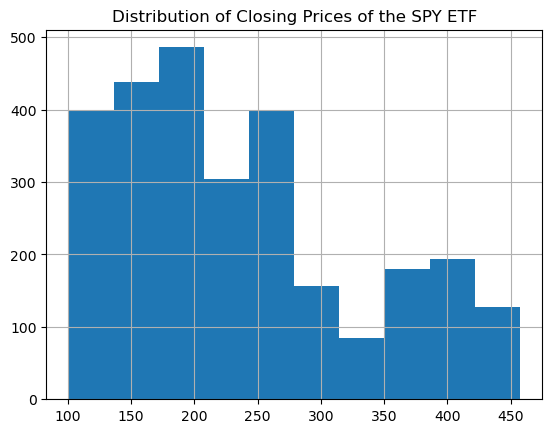

In [509]:
equity.hist()
plt.title("Distribution of Closing Prices of the SPY ETF")

Text(0.5, 1.0, 'Distribution of Closing Prices of the oil ETF')

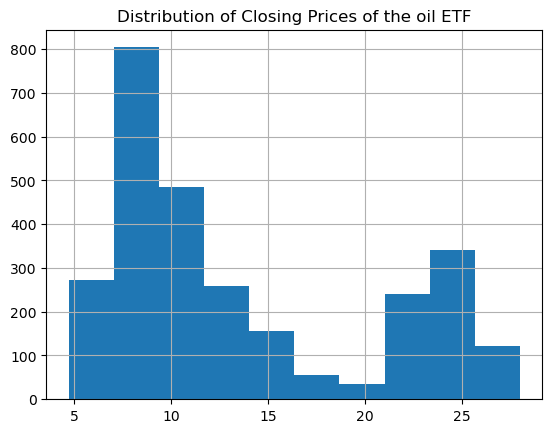

In [511]:
crude_oil.hist()
plt.title("Distribution of Closing Prices of the oil ETF")

Text(0.5, 1.0, 'Distribution of Closing Prices of the Gold ETF')

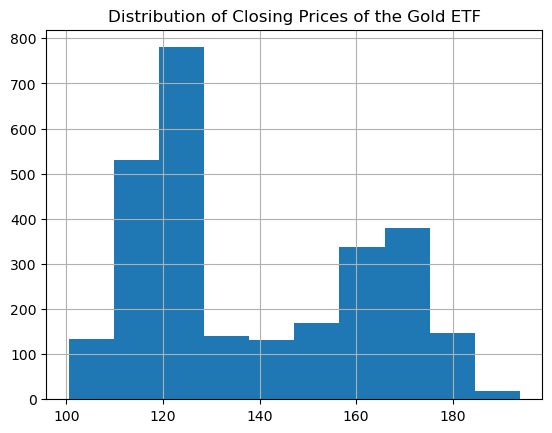

In [512]:
gold.hist()
plt.title("Distribution of Closing Prices of the Gold ETF")

Now, let us look at the scatterplots and the correlations of the series pairwise

In [516]:
gold.corr(equity)

0.5351892455296884

In [518]:
gold.corr(crude_oil)

0.13426845478173854

In [520]:
equity.corr(crude_oil)

-0.4507366077930153

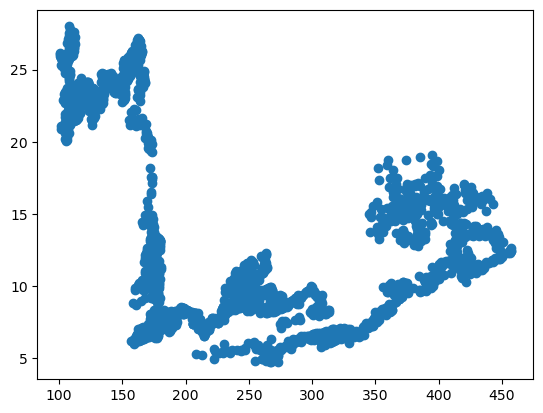

In [522]:
plt.scatter(equity, crude_oil)

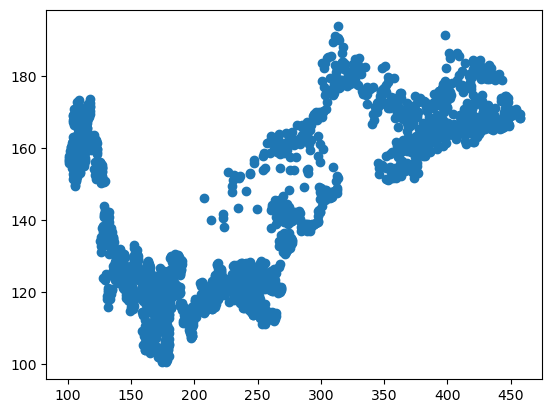

In [524]:
plt.scatter(equity, gold)

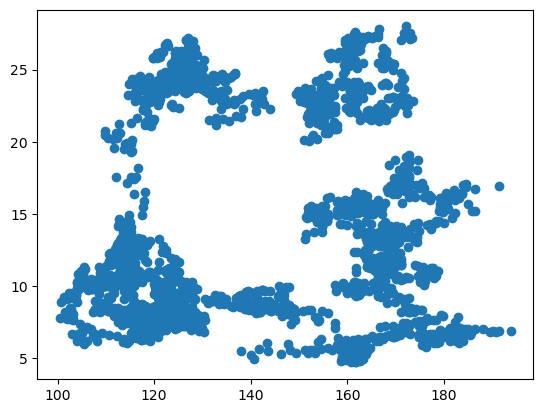

In [526]:
plt.scatter(gold, crude_oil)

## Step 2

Let us now build the LSTM model separately for each time series

First, we try model-building using just the vanilla time series

In [528]:
equity_data = equity.to_frame()

In [530]:
equity_data.tail()

,Close
Date,
2022-12-23 00:00:00-05:00,372.400513
2022-12-27 00:00:00-05:00,370.931946
2022-12-28 00:00:00-05:00,366.322113
2022-12-29 00:00:00-05:00,372.915985
2022-12-30 00:00:00-05:00,371.933655


We define the train, test and validation samples

In [533]:
val_split = 0.15
train_split = 0.55
train_size = int(len(equity_data) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(equity_data) - train_size)

In [535]:
window_size = 25

In [537]:
train_set = equity_data[0:train_size]
test_set = equity_data[train_size:]

In [539]:
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.fit_transform(test_set)

In [541]:
X_train = []
y_train = [] 

X_test = []
y_test = [] 

for i in range(window_size, train_set.shape[0]):
    X_train.append(train_set[i-window_size: i])
    y_train.append(train_set[i, 0])

for i in range(window_size, test_set.shape[0]):
    X_test.append(test_set[i-window_size: i])
    y_test.append(test_set[i, 0])

#x_train, y_train = np.array(x_train), np.array(y_train) 

In [543]:
X_train, y_train = np.array(X_train), np.array(y_train) 
X_test, y_test = np.array(X_test), np.array(y_test)

Now, let us build a basic LSTM model

In [546]:
seed = 1234
n_dropout = 0
model = Sequential()
model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(x_train.shape[1], 1),
    )
)

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [548]:
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))

In [550]:
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_79 (LSTM)                       │ (None, 25, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_80 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_62 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_81 (LSTM)                       │ (None, 25, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_63 (Dropout)                 │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_82 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_64 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_83 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_65 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_46 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_47 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_48 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,140,609 (4.35 MB)

 Trainable params: 1,140,609 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [552]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
20/20 - 20s - 999ms/step - loss: 0.2317 - val_loss: 0.0244
Epoch 2/100
20/20 - 6s - 289ms/step - loss: 0.0726 - val_loss: 0.0959
Epoch 3/100
20/20 - 6s - 295ms/step - loss: 0.0327 - val_loss: 0.0133
Epoch 4/100
20/20 - 6s - 293ms/step - loss: 0.0243 - val_loss: 0.0155
Epoch 5/100
20/20 - 6s - 289ms/step - loss: 0.0206 - val_loss: 0.0209
Epoch 6/100
20/20 - 6s - 289ms/step - loss: 0.0203 - val_loss: 0.0209
Epoch 7/100
20/20 - 6s - 289ms/step - loss: 0.0199 - val_loss: 0.0142
Epoch 8/100
20/20 - 6s - 288ms/step - loss: 0.0198 - val_loss: 0.0283


In [554]:
y_pred = model.predict(X_test)
print(y_pred.shape)
r2_score(y_test, y_pred)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step
(1221, 1)


0.9499102759059467

<Axes: >

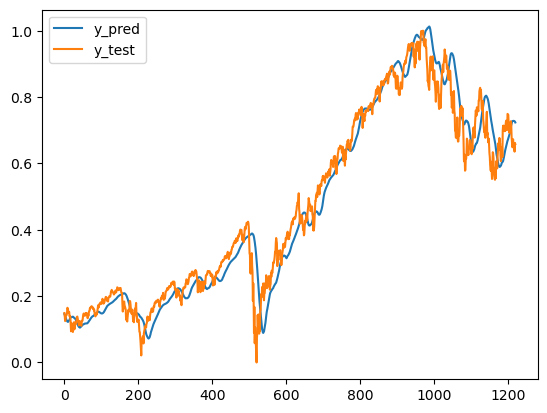

In [556]:
df = pd.DataFrame()
df["y_pred"] = pd.DataFrame(y_pred)
df["y_test"] = pd.Series(y_test)
df.plot()

Now, for the other series

In [568]:
crude_oil_data = crude_oil.to_frame()

In [570]:
train_set = crude_oil_data[0:train_size]
test_set = crude_oil_data[train_size:]

In [572]:
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.fit_transform(test_set)

In [574]:
X_train = []
y_train = [] 

X_test = []
y_test = [] 

for i in range(window_size, train_set.shape[0]):
    X_train.append(train_set[i-window_size: i])
    y_train.append(train_set[i, 0])

for i in range(window_size, test_set.shape[0]):
    X_test.append(test_set[i-window_size: i])
    y_test.append(test_set[i, 0])

#x_train, y_train = np.array(x_train), np.array(y_train) 

In [576]:
X_train, y_train = np.array(X_train), np.array(y_train) 
X_test, y_test = np.array(X_test), np.array(y_test)

Model Building

In [579]:
seed = 1234
n_dropout = 0
model = Sequential()
model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(x_train.shape[1], 1),
    )
)

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [581]:
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(Dense(64))
model.add(Dense(1))

In [582]:
model.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_84 (LSTM)                       │ (None, 25, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_85 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_66 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_86 (LSTM)                       │ (None, 25, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_67 (Dropout)                 │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_87 (LSTM)                       │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_68 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_49 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_50 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 711,553 (2.71 MB)

 Trainable params: 711,553 (2.71 MB)

 Non-trainable params: 0 (0.00 B)

In [585]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=15, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
20/20 - 14s - 711ms/step - loss: 0.3458 - val_loss: 0.1321
Epoch 2/100
20/20 - 4s - 203ms/step - loss: 0.0891 - val_loss: 0.0845
Epoch 3/100
20/20 - 4s - 202ms/step - loss: 0.0416 - val_loss: 0.0234
Epoch 4/100
20/20 - 4s - 198ms/step - loss: 0.0345 - val_loss: 0.0138
Epoch 5/100
20/20 - 4s - 199ms/step - loss: 0.0338 - val_loss: 0.0149
Epoch 6/100
20/20 - 4s - 200ms/step - loss: 0.0340 - val_loss: 0.0147
Epoch 7/100
20/20 - 4s - 199ms/step - loss: 0.0329 - val_loss: 0.0137
Epoch 8/100
20/20 - 4s - 198ms/step - loss: 0.0329 - val_loss: 0.0140
Epoch 9/100
20/20 - 4s - 204ms/step - loss: 0.0333 - val_loss: 0.0137
Epoch 10/100
20/20 - 4s - 199ms/step - loss: 0.0329 - val_loss: 0.0137
Epoch 11/100
20/20 - 4s - 199ms/step - loss: 0.0321 - val_loss: 0.0140
Epoch 12/100
20/20 - 4s - 197ms/step - loss: 0.0316 - val_loss: 0.0139
Epoch 13/100
20/20 - 4s - 196ms/step - loss: 0.0317 - val_loss: 0.0135
Epoch 14/100
20/20 - 4s - 197ms/step - loss: 0.0321 - val_loss: 0.0136
Epoch 15/100
2

In [586]:
y_pred = model.predict(X_test)
print(y_pred.shape)
r2_score(y_test, y_pred)

39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step
(1221, 1)


0.9752367327308663

<Axes: >

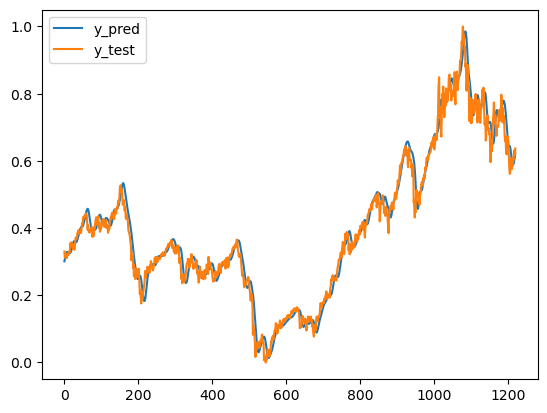

In [587]:
df = pd.DataFrame()
df["y_pred"] = pd.DataFrame(y_pred)
df["y_test"] = pd.Series(y_test)
df.plot()

In [591]:
gold_data = gold.to_frame()

In [593]:
gold_data.tail()

,Close
Date,
2022-12-23 00:00:00-05:00,167.259995
2022-12-27 00:00:00-05:00,168.669998
2022-12-28 00:00:00-05:00,167.910004
2022-12-29 00:00:00-05:00,168.850006
2022-12-30 00:00:00-05:00,169.639999


In [595]:
train_set = gold_data[0:train_size]
test_set = gold_data[train_size:]

In [597]:
scaler = MinMaxScaler()
train_set = scaler.fit_transform(train_set)
test_set = scaler.fit_transform(test_set)

In [599]:
X_train = []
y_train = [] 

X_test = []
y_test = [] 

for i in range(window_size, train_set.shape[0]):
    X_train.append(train_set[i-window_size: i])
    y_train.append(train_set[i, 0])

for i in range(window_size, test_set.shape[0]):
    X_test.append(test_set[i-window_size: i])
    y_test.append(test_set[i, 0])

#x_train, y_train = np.array(x_train), np.array(y_train) 

In [601]:
X_train, y_train = np.array(X_train), np.array(y_train) 
X_test, y_test = np.array(X_test), np.array(y_test)

In [603]:
seed = 1234
n_dropout = 0
model = Sequential()
model.add(
    LSTM(
        units=128,
        return_sequences=True,
        activation="relu",
        input_shape=(x_train.shape[1], 1),
    )
)

C:\Users\susha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [605]:
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=128, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=256, return_sequences=True, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(LSTM(units=64, return_sequences=False, activation="tanh"))
model.add(Dropout(n_dropout, seed=seed))
model.add(Dense(64))
model.add(Dense(32))
model.add(Dense(1))

In [607]:
model.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_88 (LSTM)                       │ (None, 25, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_89 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_69 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_90 (LSTM)                       │ (None, 25, 128)             │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_70 (Dropout)                 │ (None, 25, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_91 (LSTM)                       │ (None, 25, 256)             │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_71 (Dropout)                 │ (None, 25, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_92 (LSTM)                       │ (None, 64)                  │          82,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_72 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_51 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,140,609 (4.35 MB)

 Trainable params: 1,140,609 (4.35 MB)

 Non-trainable params: 0 (0.00 B)

In [609]:
hp_lr = 1e-4
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_absolute_error"
)

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
20/20 - 20s - 1s/step - loss: 0.2433 - val_loss: 0.1415
Epoch 2/100
20/20 - 6s - 302ms/step - loss: 0.0928 - val_loss: 0.0559
Epoch 3/100
20/20 - 6s - 286ms/step - loss: 0.0585 - val_loss: 0.0413
Epoch 4/100
20/20 - 6s - 288ms/step - loss: 0.0482 - val_loss: 0.0333
Epoch 5/100
20/20 - 6s - 315ms/step - loss: 0.0488 - val_loss: 0.0321
Epoch 6/100
20/20 - 6s - 297ms/step - loss: 0.0480 - val_loss: 0.0319
Epoch 7/100
20/20 - 11s - 526ms/step - loss: 0.0483 - val_loss: 0.0325
Epoch 8/100
20/20 - 6s - 290ms/step - loss: 0.0477 - val_loss: 0.0313
Epoch 9/100
20/20 - 6s - 292ms/step - loss: 0.0475 - val_loss: 0.0314
Epoch 10/100
20/20 - 6s - 289ms/step - loss: 0.0466 - val_loss: 0.0310
Epoch 11/100
20/20 - 6s - 284ms/step - loss: 0.0450 - val_loss: 0.0305
Epoch 12/100
20/20 - 6s - 290ms/step - loss: 0.0456 - val_loss: 0.0321
Epoch 13/100
20/20 - 6s - 287ms/step - loss: 0.0448 - val_loss: 0.0311
Epoch 14/100
20/20 - 6s - 287ms/step - loss: 0.0442 - val_loss: 0.0298
Epoch 15/100
20/

In [610]:
y_pred = model.predict(X_test)
print(y_pred.shape)
r2_score(y_test, y_pred)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step
(1221, 1)


0.9802103954688478

<Axes: >

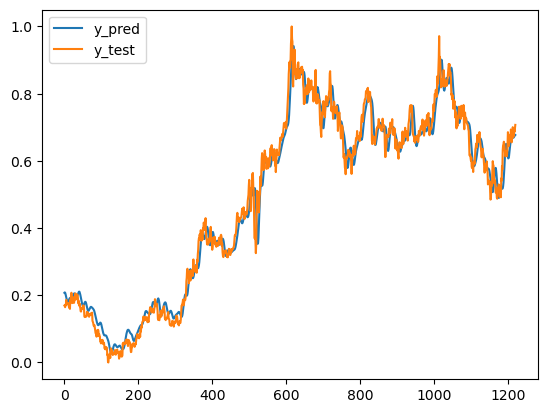

In [611]:
df = pd.DataFrame()
df["y_pred"] = pd.DataFrame(y_pred)
df["y_test"] = pd.Series(y_test)
df.plot()